# Assigment 6

## Upload your code (.ipynb) on Learn dropbox and submit pdfs of the code and the mathematical questions to Crowdmark.

## -----------------------------------------------------------------------------------------------------------

## Rank-Sparsity 

## Question 1

Implement ADMM for the problem of separating a background image from foreground interference. Download the datasets at: http://www.svcl.ucsd.edu/projects/background_subtraction/JPEGS.tar.gz 

You will have to solve this problem:

$$
\begin{align*}
\mbox{minimize} & \ \|L\|_* + \gamma \|M\|_1 \\
\mbox{subj. to:} & \ L+M=A
\end{align*}
$$

where $\gamma>0$ is a parameter that you will have to tune. 

Use only the first dataset, birds, which contains 71 jpeg images each with 37752 gray-scale pixels. Form a matrix A of size 37752 x 71 with these images. 

When you are done, print the background image (that is, columns of the component L) for frames 1, 11, ..., 71. 

Note that this algorithm requires SVD. Computing the SVD in the usual way is very expensive for this dataset because the U matrix in SVD has size 37752 × 37752. You will have to utilize the "economy" SVD in https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.svd.html
or 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html
by setting the option full_matrices = False.

Marks: 33.

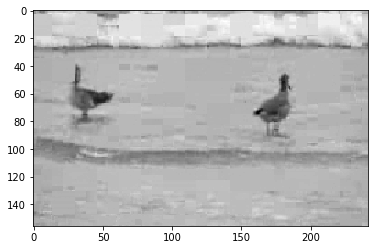

In [11]:
import numpy as np
from numpy.linalg import norm

import scipy
from scipy import linalg

import matplotlib.pyplot as plt

import cv2
import sys

image = cv2.imread('JPEGS/birds/frame_1.jpg', cv2.IMREAD_GRAYSCALE)
row, col = image.shape[0], image.shape[1]

A_row = 37752
A_col = 71

A = np.zeros([A_row, A_col])
for i in range(A_col):
    file_path = 'JPEGS/birds/frame_' + str(i+1) +'.jpg'
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = np.reshape(image, (A_row))
    A[:,i] = image
plt.imshow(A[:,0].reshape((row, col)), cmap = 'gray')

In [16]:
def proximalM(m, g, gamma):
    cond = gamma/g
    res = np.where(m>=cond, m-cond, m)
    res = np.where(np.absolute(m)<=cond, 0, res)
    res = np.where(m<=-cond, m+cond, res)
    return res

In [17]:
def proximalL(l, g):
    u, s, vh = linalg.svd(l, full_matrices=False)
    cond = 1/g
    proximal = np.where(s>=cond, s-cond, 0)
    res = scipy.linalg.diagsvd(proximal, len(proximal), len(proximal))
    res = (u.dot(res)).dot(vh)
    return res

In [19]:
def admm(A, g, gamma, epsilon, max_iters):
    Y = np.zeros(A.shape)
    M = np.random.rand(A.shape[0], A.shape[1])
    
    i = 0
    while i<max_iters:
        l = -M+A-Y/g
        L = proximalL(l, g)
        m = -L+A-Y/g
        M = proximalM(m, g, gamma)
        Y = Y+g*(L+M-A)
        i += 1
        if i%100 == 0: print(i)
        eps = norm(L+M-A, 2)
        
        if eps<epsilon: break
            
    return L, M

In [20]:
gamma = 1/550
epsilon = 1e-21
max_iteration = 5000
g = 1

res, m_ = admm(A, g, gamma, epsilon, max_iteration)
print(res)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
[[148.01700648 147.74396009 147.10641624 ... 144.20526249 143.79219694
  144.09663895]
 [147.99444873 147.76324049 147.11402609 ... 143.48877677 143.14043352
  143.48847078]
 [148.21733155 148.08142306 147.39111116 ... 142.33394804 142.20463212
  142.55591298]
 ...
 [156.25116689 156.11666534 155.83421768 ... 150.11583057 149.78279217
  149.2034742 ]
 [155.93358098 155.78942522 155.44588431 ... 149.72072848 149.73380951
  149.42643847]
 [156.99444632 156.91065464 156.37298556 ... 149.78119123 149.73760735
  149.38804366]]


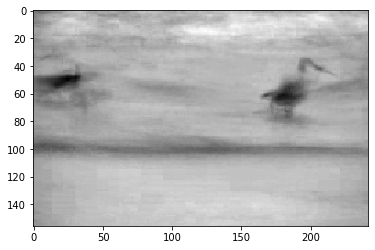

In [21]:
plt.imshow(res[:,0].reshape((row,col)), cmap = 'gray')

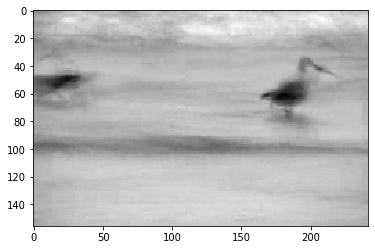

In [22]:
plt.imshow(res[:,10].reshape((row,col)), cmap = 'gray')

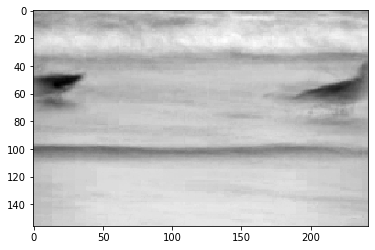

In [23]:
plt.imshow(res[:,20].reshape((row,col)), cmap = 'gray')

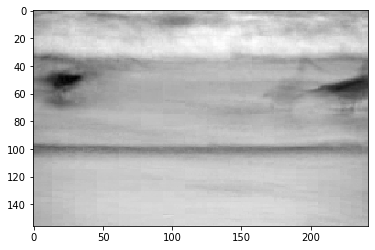

In [24]:
plt.imshow(res[:,30].reshape((row,col)), cmap = 'gray')

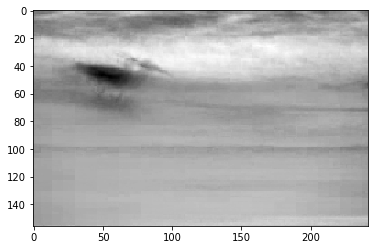

In [25]:
plt.imshow(res[:,40].reshape((row,col)), cmap = 'gray')

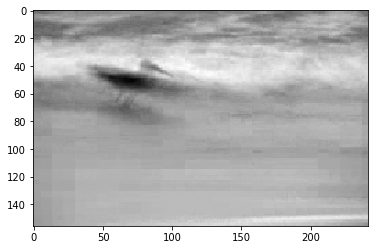

In [26]:
plt.imshow(res[:,50].reshape((row,col)), cmap = 'gray')

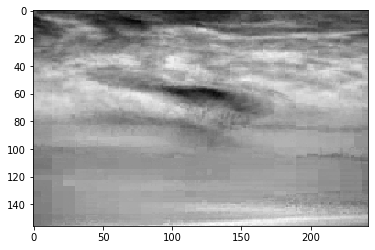

In [27]:
plt.imshow(res[:,60].reshape((row,col)), cmap = 'gray')

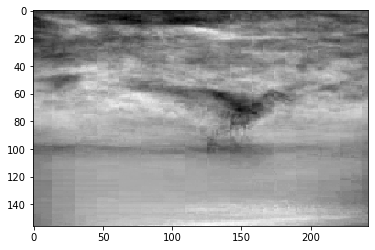

In [28]:
plt.imshow(res[:,70].reshape((row,col)), cmap = 'gray')

## Robust Linear Regression

## Question 2

Implement AM-RR (alternating minimization for robust regresion) on the same dataset as Q1. Form a matrix X whose columns are the first 70 bird images. Form a vector y that is the 71st image. Then try to fit $$y\approx Xw $$ using the Robust Linear Regression problem. 

Illustrate the following two plots. The first plot should show the image that was not covered by set S (S is an output of AM-RR). In other words, y(S^c), where S^c is the complement of S with respect to the set of all pixels. Pixels in S should be set to white (255, when the grey scale image is from 0 to 255) in this image. 

The second plot should show the image indexed by S, in other words, X(S,:)w. Fill in the entries not indexed by S 
to white. 

Marks: 33.

In [31]:
len = 70
k = 700
max_iteration = 1000
epsilon = 1e-3

Y = A[:,len]
X = A[:,:len]

def lip(x):
    return norm(x, 2)**2

In [32]:
def amrr(x, y, k, epsilon, max_iters):
    n = y.shape[0]
    tmp = [i for i in range(n-k)]
    r = np.array(tmp)
    weight = np.zeros(len)

    i = 0
    while i<max_iters:
        x_ = x[r]
        y_ = y[r]
        step = 1/lip(x_)
        weight = weight-step*np.sum(np.multiply(x_.dot(weight)-y_, x_.T), axis=1)
        
        s = np.square(y-x.dot(weight))
        r = np.argsort(s, axis=0)[:n-k]
    
        i+=1
        eps = norm(y-X.dot(weight), 2)
        if eps<epsilon: break
#         print(i)
        
    return weight, r
    

In [33]:
weight, idx = amrr(X, Y, k, epsilon, max_iteration)

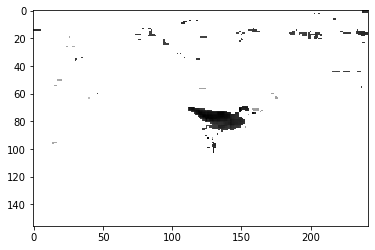

In [34]:
res = Y
res[idx] = 255
plt.imshow(res.reshape((row, col)), cmap = 'gray')

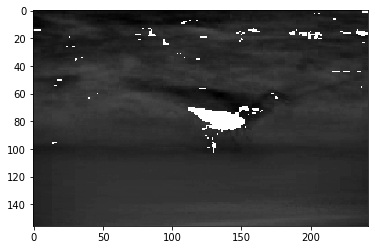

In [35]:
Yest = X[idx].dot(weight)
res = np.full(Y.shape, 255)
res[idx] = Yest
plt.imshow(res.reshape((row, col)), cmap = 'gray')

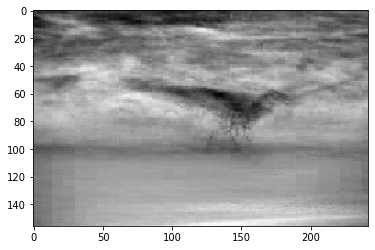

In [36]:
plt.imshow(X.dot(weight).reshape((row, col)), cmap = 'gray')

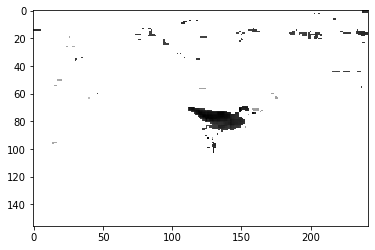

In [37]:
plt.imshow(A[:,70].reshape((row, col)), cmap = 'gray')

## Nonnegative matrix factorization

Consider the nonnegative matrix factorization problem. For this problem, we showed that the modified multiplicative updates algorithm satisfies the nonnegativity constraints at each iteration. Consider now the nonnegative sparse coding problem:
$$
\begin{align*}
\mbox{minimize}_{W,H} &  \ F(W,H):= \frac{1}{2}\| WH-X\|_F^2 + \lambda \|H\|_1\\
\mbox{subj. to} & \ W_{ij}\ge 0 \ \forall i,j \\
                &  \ H_{ij}\ge 0 \ \forall i,j,
\end{align*}
$$
where 
$$
\|H\|_1 = \sum_{i,j} |H_{ij}|.
$$
and $\lambda \ge 0$ is a parameter that controls the effect of the l1-norm. This problem is called sparse coding because the l1-norm forces a lot of weights in matrix $H$ to become zero.

## Question 3

Show that the modified multiplicative updates algorithm for the above nonnegative sparse coding problem also satisfies the nonnegative constraints at each iteration. 

Marks: 5

## Question 4

Use the face dataset, see Assigment 5. Set parameter $r=6$ in the nonnegative factorization problem. Plot $\frac{1}{2}\| WH-X\|_F^2$ as $\lambda$ increases.

Marks: 12

## Question 5

Choose a $\lambda$ and extract the features matrix $W$ by solving the nonnegative matrix factorization problem. Report the 6 features of the faces dataset, i.e., the 6 columns of matrix $W$. You can report the features by visualizing them in a similar way to the above example.

Marks: 12

## Question 6

For your chosen $\lambda$, which are the most important features of the first 6 faces? Provide the code on how to obtain the most important features.

Marks: 5

Dataset consists of 400 faces


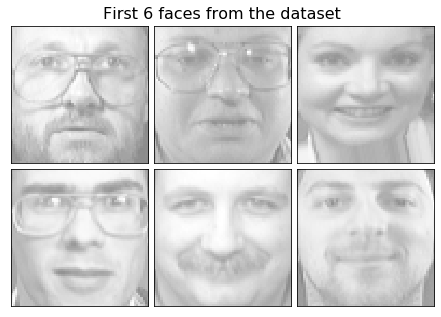

In [12]:
# This piece of code is for loading data and visualizing 
# the first 6 images in the dataset.

# Useful packages for loading the data and plotting
from numpy.random import RandomState
from sklearn.datasets import fetch_olivetti_faces

n_row, n_col = 2, 3
image_shape = (64, 64)
rng = RandomState(0)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2.*n_col, 2.26*n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)

faces = dataset.data
n_samples = faces.shape[0]
print("Dataset consists of %d faces" % n_samples)
plot_gallery("First 6 faces from the dataset", faces[:6])    

In [13]:
def proximalL1 (z, x):
    result = np.where(z>=x, z-x, 0)
    result = np.where(z<=-x, z+x, result)
    return result

In [14]:
def obj_func(W, H, X):
    result = W.dot(H)-X
    return np.trace(result.dot(result.T))/2

In [15]:
def gradientW(W, H, X):
    result = W.dot(H)-X
    return result.dot(H.T)

def gradientH(W, H, X):
    result = W.dot(H)-X
    return W.T.dot(result)

In [16]:
def WHbar(WH, gradientWH, sigma):
    maxWH = np.where(WH>sigma, WH, sigma)
    WH = np.where(gradientWH>=0, WH, maxWH)
    return WH

In [17]:
def extract(x, sigma, delta, lambda_, max_iters):
    H = np.random.random([6, x.shape[1]])
    W = np.random.random([x.shape[0], 6])
    
    S = np.diag(1/(W.sum(axis=0)))
    Sinv = np.diag(W.sum(axis=0))
    
    deltaW = delta*np.ones(W.shape)
    deltaH = delta*np.ones(H.shape)
    
    i = 0
    while i<max_iters:
        gradH = gradientH(W, H, x)
        Hbar = WHbar(H, sigma, gradH)
        
        gradW = gradientW(W, H, x)
        Wbar = WHbar(W, sigma, gradW)
        
        denomH = (W.T.dot(W)).dot(Hbar)+deltaH
        
        alpha = np.divide(Hbar, denomH)
        z = H-alpha*gradH
        
        H_ = proximalL1(z, alpha*lambda_)
        
        gradW_ = gradientW(W, H_, x)
        denomW = Wbar.dot(H.dot(H.T))+deltaW
        W_ = W-np.divide(Wbar, denomW)*gradW_
        
        S = np.diag(1/W_.sum(axis=0))
        Sinv = np.diag(W_.sum(axis=0))
        
        W = W_.dot(S)
        H = Sinv.dot(H_)
        
        i += 1
    return W, H

In [18]:
X = faces.T
sigma = 0.5
delta = 0.5
max_iteration = 400

list = []
for lam in np.linspace(0.01, 0.10, 10):
    W, H = extract(X, sigma, delta, lam, max_iteration)
    list.append(obj_func(W, H, X))
print(list)

[7046.2878257983775, 7041.306276458475, 7074.362417292647, 6982.356250748417, 7058.221121488241, 7164.772941439374, 7164.802645872411, 7197.650996184966, 7270.2909244777875, 7268.174057538009]


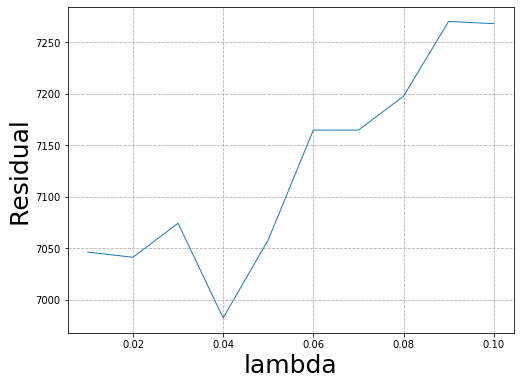

In [19]:
fig = plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.01, 0.10, 10), list, linewidth=1.0)
plt.xlabel("lambda", fontsize=25)
plt.ylabel("Residual", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

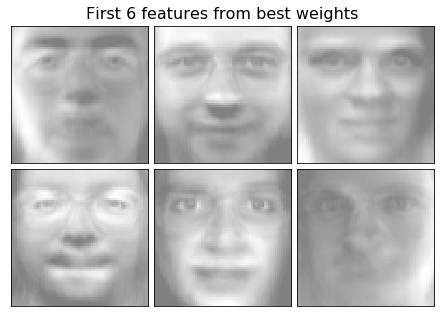

In [20]:
lambda_ = 0.03
w_extract, h_extract = extract(X, sigma, delta, lambda_, max_iteration)
plot_gallery("First 6 features from best weights", w_extract.T[:6])

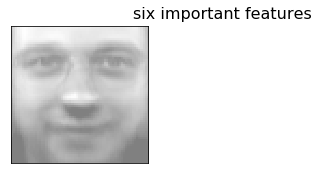

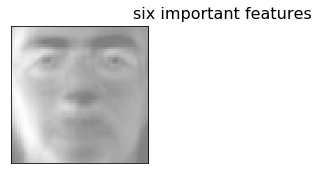

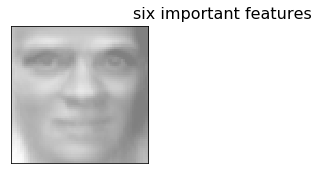

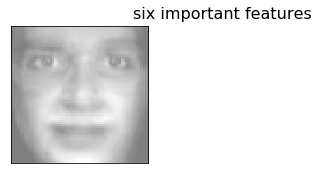

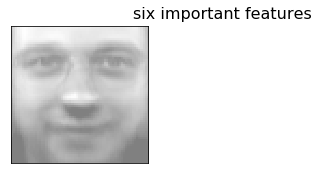

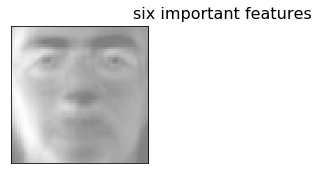

In [21]:
for i in range(6):
    six_features = h_extract[:,i]
    sortedIdx = np.argsort(six_features, axis=0)[::-1]
    plot_gallery("six important features", w_extract.T[sortedIdx[:1]]) 